····················································································································································································································································
COSAS QUE HACER:<br>
Ver a ojo dibujando seis características noooo
Correlacion dibujando matriz y juntar(temperatura con color)
1) ESCALAR
2) PCA DOS O TRES NO VAMOS A PODER PINTAR MÁS.UTILIZANDO COMPONENTES PRINCIPALES.
3) PRUEBA CON DOS¿?QUE VARIABILIDAD, CERCA DE 80 OKEYYYY, SOLO DOS, SINO PRUEBA CON TRES
4) SI ES CON TRES QUE SE PUEDA MOVER CON EL RATON. EL CHIVA QUE DOSSSS Y PINTASSS.
5) JERARQUICO, KMEANS, DBSCAN, ETC.
6) 6-7 CLUSTERS, HAY QUE CARACTERIZARLAS Y GENERAR BOX-PLOTS PARA CADA CLASE Y VER COMO SE DIVIDEN
LAS CARACTERÍSTICAS
7)VER VALORES DE CIENTIFICOS Y CARACTERIZAR, SE PUEDE PROBAR ARBOL DE DECISIÓN
····················································································································································································································································


----------------------------------------------------------------------------------------------------------------
## IMPORTS
----------------------------------------------------------------------------------------------------------------

In [70]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import time
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans as KMeans_sklearn
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

----------------------------------------------------------------------------------------------------------------
## IMPLEMENTACIÓN K-MEANS
----------------------------------------------------------------------------------------------------------------

····················································································································································································································································
Vamos a realizar nuestra propia implementación de K-Means. Nuestra implementación de K-Means tiene los siguientes parámetros:<br>
-n_clusters: determina el número 𝐾 de clusters(grupos) que se van a generar.<br>
-max_iter: número máximo de iteraciones permitidas.<br>
-tol: Distancia entre los centroides antiguos y los nuevos, en el que el algoritmo se detiene, asumiendo que ha alcanzado una solución suficientemente buena.
····················································································································································································································································

In [71]:
# Creación de la clase K-means para la implementación del algoritmo.

class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4):   #Número de clusters tres.
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        # Inicializar centroides aleatoriamente
        centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            # Calcular distancias entre cada punto y los centroides
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1)
            
            # Asignar cada punto al centroide más cercano
            labels = np.argmin(distances, axis=-1)
            
            # Actualizar los centroides como la media de los puntos asignados a cada grupo
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])

            if np.linalg.norm(new_centroids - centroids) < self.tol:
                break

            centroids = new_centroids

        self.centroids = centroids
        self.labels_ = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1), axis=-1)
        return self

    def predict(self, X):
        return np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=-1), axis=-1)


····················································································································································································································································
Para poder ver si nuestra implementación de K-Means es correcta y compararla con la de sklearn vamos a generar datos de prueba con make_blobs y ver los resultados en dos gráficas una con la de sklearn y otra con nuestra implementación y poder comparar ambos resultados.
····················································································································································································································································

Tiempo de ejecución de nuestro KMeans: 0.0009992122650146484
Tiempo de ejecución de KMeans sklearn: 0.00599980354309082
Centroides personalizados:
 [[-0.33514647  3.62624134]
 [-1.37324398  7.75368871]
 [ 1.98726097  0.90144281]]
Centroides scikit-learn:
 [[-0.33514647  3.62624134]
 [-1.37324398  7.75368871]
 [ 1.98726097  0.90144281]]


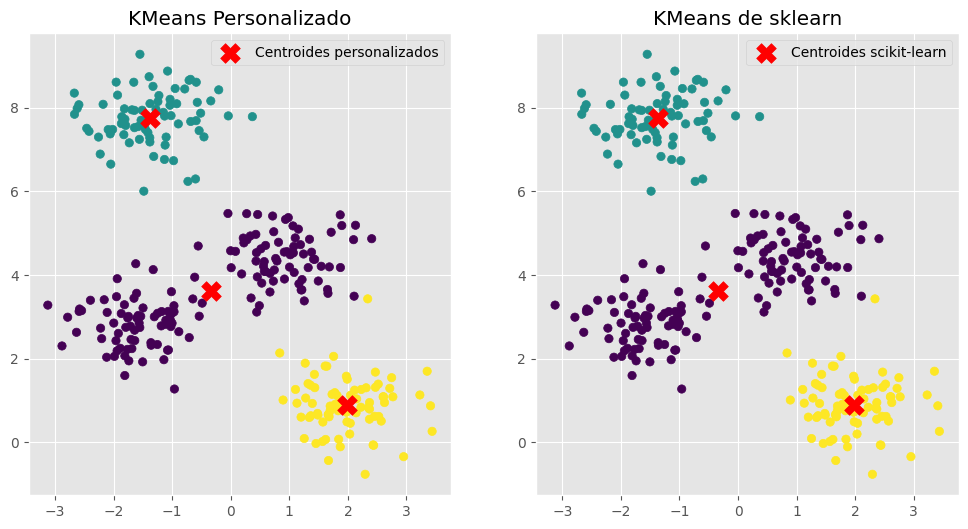

In [72]:
# Generar datos de prueba con make_blobs
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

# Inicializar y ajustar el modelo de KMeans personalizado
tiempoKmeans = time.time()
kmeans_custom = KMeans(n_clusters=3)
kmeans_custom.fit(X)
labels_custom = kmeans_custom.predict(X)
centroids_custom = kmeans_custom.centroids
tiempo_ejecucion = time.time()-tiempoKmeans
print("Tiempo de ejecución de nuestro KMeans:", tiempo_ejecucion)

# Inicializar y ajustar el modelo de KMeans de scikit-learn
tiempoKmeans = time.time()
kmeans_sklearn = KMeans_sklearn(n_clusters=3)
kmeans_sklearn.fit(X)
labels_sklearn = kmeans_sklearn.predict(X)
centroids_sklearn = kmeans_sklearn.cluster_centers_
tiempo_ejecucion = time.time()-tiempoKmeans
print("Tiempo de ejecución de KMeans sklearn:", tiempo_ejecucion)
# Comparar los resultados
print("Centroides personalizados:\n", centroids_custom)
print("Centroides scikit-learn:\n", centroids_sklearn)

# Gráfico de los resultados
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis')
plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], marker='X', s=200, c='red', label='Centroides personalizados')
plt.title('KMeans Personalizado')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_sklearn, cmap='viridis')
plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], marker='X', s=200, c='red', label='Centroides scikit-learn')
plt.title('KMeans de sklearn')
plt.legend()

#Mostrar gráficas
plt.show()

····················································································································································································································································
Nuestra implementación de sklearn proporciona las mismas divisiones de cluster que la implementación de Kmeans de sklearn, incluso nuestra implementación es más rápida esto puede ser debido a que sklearn utiliza más parámetros y es un modelo más complejo que necesita algo más de tiempo.
····················································································································································································································································

----------------------------------------------------------------------------------------------------------------
## CARGAR LOS DATOS 
----------------------------------------------------------------------------------------------------------------

In [73]:
# Cargar los datos del csv
import pandas as pd
# Archivo CSV a cargar
archivo = "Stars2.csv"
# Cargamos el archivo y lo mostramos por pantalla.
print(pd.read_csv(archivo))
data_set = pd.read_csv(archivo)  
#Mostrar por encima los datos del csv.
data_set.head()


     Temperature              L          R    A_M  Color Spectral_Class
0           3068       0.002400     0.1700  16.12    Red              M
1           3042       0.000500     0.1542  16.60    Red              M
2           2600       0.000300     0.1020  18.70    Red              M
3           2800       0.000200     0.1600  16.65    Red              M
4           1939       0.000138     0.1030  20.06    Red              M
..           ...            ...        ...    ...    ...            ...
235        38940  374830.000000  1356.0000  -9.93   Blue              O
236        30839  834042.000000  1194.0000 -10.63   Blue              O
237         8829  537493.000000  1423.0000 -10.73  White              A
238         9235  404940.000000  1112.0000 -11.23  White              A
239        37882  294903.000000  1783.0000  -7.80   Blue              O

[240 rows x 6 columns]


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


····················································································································································································································································
Vamos a comprobar que no hay ningún valor nulo y ver los tipos de los datos a anlizar.
····················································································································································································································································

In [74]:
print('The types of the attributes are:')
print('================================')
data_set.info()

print('How many missing values per attribute:')
print('======================================')
print(data_set.isnull().sum())

The types of the attributes are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB
How many missing values per attribute:
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64


····················································································································································································································································
Hemos comprobado que hay 4 atributos con valores numéricos y los otros dos son de tipo categórico. No hay ningún dato nulo en nuestro conjunto de datos. Tenemos los siguientes atributos:<br>
-Temperature: Temperatura promedio de la superficie en grados K.<br>
-L: Luminosidad comparada con la del Sol.<br>
-R: Radio comparado con la del Sol.<br>
-A_M: Magnitud absoluta (brillo aparente de la estrella si estuviera a 10 parsec de distancia).
-Color: Color principal del espectro. Los colores proporciona información sobre su temperatura superficial y, por lo tanto, sobre su luminosidad, tamaño y otras propiedades físicas. Estrellas más calientes suelen ser azulen y las más frías rojas.(Asoociado a la clase espectral(O---> SUELEN AZULES y M---> SUELEN ROJAS))<br>
-Spectral_Class: Clasificación espectral: es un valor que identifica la presencia elementos químicos en el espectro de la estrella. Es una secuencia (O, B, A, F, G, K, M) que se asocia a las estrellas desde las más calientes O, hasta las más frías M.<br>
····················································································································································································································································

----------------------------------------------------------------------------------------------------------------
## CODIFICACIÓN VARIABLES CATEGÓRICAS A ORDINALES
----------------------------------------------------------------------------------------------------------------

····················································································································································································································································
Vamos a transformar los atributos categóricos a ordinales, para que se conserve el orden natural de las clases. Por ejemplo, en las clases espectrales O es el más caliente y M, es la más fría. Al asignar números a estas clases, mantendremos su orden de significado, con 0 representando el extremo más caliente, 1 el extremo más frío y valores intermedios reflejando el orden correspondiente entre las clases.No vamos a utilizar one-hot encoding para preservar el orden de las categorías.
····················································································································································································································································

····················································································································································································································································
Como en nuestro conjunto de datos hay mismos colores escritos de diferentes formas, vamos a modificarlo para que ese color aparezca igual en todas las instancias.
····················································································································································································································································

In [75]:
# Reemplaza los valores distintos en la columna 'color'
data_set['Color'] = data_set['Color'].replace(['Blue White', 'Blue white', 'Blue-White'], 'Blue-white')
data_set['Color'] = data_set['Color'].replace(['white'], 'White')
data_set['Color'] = data_set['Color'].replace(['yellowish-white'], 'Yellowish White')
data_set['Color'] = data_set['Color'].replace(['yellowish'], 'Yellowish')

corregido = pd.read_csv('Stars2.csv')
corregido.head()


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


····················································································································································································································································
Realizamos la codificación ordinal de los colores. 0--->RED ... 11--->BLUE.
····················································································································································································································································

In [76]:
# Define el orden de los colores
color_order = ['Red', 'Orange-Red', 'Orange', 'Pale yellow orange', 'Yellowish', 
               'yellow-white', 'Whitish', 'Yellowish White', 'White-Yellow', 'White', 
               'Blue-white', 'Blue']

# Encuentra los valores únicos en la columna "Color"
unique_colors = set(corregido['Color'])

# Encuentra los valores de la columna "Color" que no están en color_order
missing_colors = unique_colors - set(color_order)

# Imprime los valores que faltan
print("Valores de la columna Color que no están en color_order:")
for color in missing_colors:
    print(color)

# Define el diccionario de mapeo para corregir los valores incorrectos
correction_mapping = {
    'Blue white': 'Blue-white',
    'Blue White': 'Blue-white',
    'Blue-White': 'Blue-white',
    'white': 'White',
    'yellowish': 'Yellowish'
}

# Reemplaza los valores incorrectos en la columna "Color"
corregido['Color'] = corregido['Color'].replace(correction_mapping)

# Mapea los valores de color utilizando una función lambda
corregido['Color'] = corregido['Color'].map(lambda x: color_order.index(x))

# Muestra el DataFrame con la columna 'Color' reemplazada por los valores codificados
print(corregido)


Valores de la columna Color que no están en color_order:
Blue White
white
Blue-White
yellowish
Blue white
     Temperature              L          R    A_M  Color Spectral_Class
0           3068       0.002400     0.1700  16.12      0              M
1           3042       0.000500     0.1542  16.60      0              M
2           2600       0.000300     0.1020  18.70      0              M
3           2800       0.000200     0.1600  16.65      0              M
4           1939       0.000138     0.1030  20.06      0              M
..           ...            ...        ...    ...    ...            ...
235        38940  374830.000000  1356.0000  -9.93     11              O
236        30839  834042.000000  1194.0000 -10.63     11              O
237         8829  537493.000000  1423.0000 -10.73      9              A
238         9235  404940.000000  1112.0000 -11.23      9              A
239        37882  294903.000000  1783.0000  -7.80     11              O

[240 rows x 6 columns]


····················································································································································································································································
Realizamos la codificación ordinal de la clase espectral. 0--->M ... 6--->O.
····················································································································································································································································

In [77]:

# Definir el orden de las clases espectrales (de menor a mayor)
spectral_class_order = ['M', 'K', 'G', 'F', 'A', 'B', 'O']

# Mapear los valores de spectral_class utilizando una función lambda
corregido['Spectral_Class'] = corregido['Spectral_Class'].map(lambda x: spectral_class_order.index(x))

# Muestrar el DataFrame con la columna 'Spectral_Class' reemplazada por los valores codificados
print(corregido)


     Temperature              L          R    A_M  Color  Spectral_Class
0           3068       0.002400     0.1700  16.12      0               0
1           3042       0.000500     0.1542  16.60      0               0
2           2600       0.000300     0.1020  18.70      0               0
3           2800       0.000200     0.1600  16.65      0               0
4           1939       0.000138     0.1030  20.06      0               0
..           ...            ...        ...    ...    ...             ...
235        38940  374830.000000  1356.0000  -9.93     11               6
236        30839  834042.000000  1194.0000 -10.63     11               6
237         8829  537493.000000  1423.0000 -10.73      9               4
238         9235  404940.000000  1112.0000 -11.23      9               4
239        37882  294903.000000  1783.0000  -7.80     11               6

[240 rows x 6 columns]
